# Logistic Regression from Scratch

This notebook implements **Logistic Regression** using **Batch Gradient Descent**,  **Stochastic Gradient Descent (SGD)** and **Newton-Raphson** methods, 
as taught in **Stanford's CS229: Machine Learning (Autumn 2018, Lecture 3)** by Andrew Ng.

It includes:
- Feature normalization using **Z-score** and **Min-Max Scaling**
- Optimization using **Batch Gradient Descent**
- Optimization using **Stochastic Gradient Descent**
- Optimization using **Newton-Rapshon(Fisher Scoring)**
- Loss curve visualization for training diagnostics
- Inference using saved model parameters
- 3D visualization of decision surface and predictions

> 📘 This is part of a broader `ml-from-scratch` project implementing foundational machine learning algorithms using only **NumPy** and **pandas** for educational and intuitive understanding.


In [1]:
import pickle
import numpy as np
import pandas as pd
from numpy import ndarray
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D

In [12]:
class LogisticRegression():
    def __init__(self):
        self.x_mean: ndarray = None
        self.x_std: ndarray = None
        self.x_max: ndarray = None
        self.x_min: ndarray = None
        self.x_norm: ndarray = None
        self.theta: ndarray = None
        self.thetaSGD: ndarray = None
        self.thetaNR: ndarray = None
        self.normtype: str = None
        self.add_bias: bool = None
        self.is_norm: bool = False
    @staticmethod
    def g(z: ndarray) -> ndarray:
        return 1 / (1 + np.exp(-z))
    
    @staticmethod
    def h(x: ndarray, theta:ndarray) -> ndarray:
        return LogisticRegression.g(np.dot(x, theta))
    @staticmethod
    def l(theta: ndarray, x: ndarray, y: ndarray):
        """log likelihood of `theta`"""
        m = x.shape[0]
        h=LogisticRegression.h
        return (1 / m) * np.sum((y *np.log(h(x,theta))) + ((1 - y) * np.log(1 - h(x, theta))))

    @staticmethod
    def J(theta: ndarray, x: ndarray, y: ndarray):
        return -LogisticRegression.l(theta, x, y)
    
    @staticmethod
    def predict(X: ndarray, theta:ndarray):
        return (LogisticRegression.h(X, theta) >= 0.5).astype(int)
    def normalize(self, x_train: ndarray, add_bias: bool=True, normtype:str='z-score'):

        if normtype=='z-score':
            self.x_mean, self.x_std = x_train.mean(axis=0), x_train.std(axis=0)
            self.x_std[self.x_std == 0] = 1
            self.x_norm = (x_train - self.x_mean) / self.x_std
            self.normtype = 'z-score'
            print("Applied z-score")
        if normtype=='min-maxScaling':
            self.x_max = x_train.max(axis=0)
            self.x_min=x_train.min(axis=0)
            self.x_norm= (x_train - self.x_min) / (self.x_max - self.x_min)
            self.normtype = 'min-maxScaling'
            print("Applied Min-Max Scaling")

        if normtype not in ['z-score', 'min-maxScaling']:
            raise ValueError("Invalid Normalization type, choose 'z-score' or 'min-maxScaling'.")
        
        if add_bias:
            x_0 = np.ones((x_train.shape[0],1))
            self.x_norm = np.hstack([x_0,self.x_norm])
        self.add_bias=add_bias
        self.is_norm=True

        return
    
    def train(self, x_train: ndarray, y_train: ndarray, alpha: float,theta:ndarray=None,epoch: int =100, normtype: str='z-score', add_bias=True):
        if not self.is_norm:
            self.normalize(x_train,add_bias,normtype)
        m = self.x_norm.shape[0]
        if theta is None:
            theta = np.zeros((self.x_norm.shape[1], 1))
        losses = []
        
        for _ in range(epoch):
            error = self.h(self.x_norm, theta) - y_train 
            grad = (1 / m) * (self.x_norm.T @ error)
            theta -= alpha * grad
            losses.append(self.J(theta,self.x_norm, y_train))
        
        self.theta = theta
        print(f"[Batch GD] Final Loss = {self.J(theta,self.x_norm, y_train)}")
        y_pred = self.predict(self.x_norm, theta)
        accuracy = np.mean(y_pred == y_train)
        print("Training Accuracy:", accuracy * 100, "%")

        plt.plot(range(1, epoch + 1), losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.title("Batch GD Loss Curve")
        plt.show()

        return theta

    def trainSGD(self, x_train: ndarray, y_train: ndarray, alpha: float,theta:ndarray=None,epoch: int =100, normtype: str='z-score', add_bias=True):
        if not self.is_norm:
            self.normalize(x_train,add_bias,normtype)
        m = self.x_norm.shape[0]
        if theta is None:
            theta = np.zeros((self.x_norm.shape[1], 1))
        losses = []
        
        for _ in range(epoch):
            for i in range(m):
                xi = self.x_norm[i].reshape(1, -1)  # (1, n)
                yi = y_train[i]
                error = self.h(xi, theta) - yi
                grad = xi.T * error
                theta -= alpha * grad
            losses.append(self.J(theta,self.x_norm, y_train))
        self.thetaSGD = theta
        print(f"[SGD] Final Loss = {self.J(theta,self.x_norm, y_train)}")
        y_pred = self.predict(self.x_norm, theta)
        accuracy = np.mean(y_pred == y_train)
        print("Training Accuracy:", accuracy * 100, "%")

        plt.plot(range(1, epoch + 1), losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.title("SGD Loss Curve")
        plt.show()
    
    def trainNR(self, x_train: ndarray, y_train: ndarray ,theta:ndarray=None,epoch: int =100, normtype: str='z-score', add_bias=True):
        if not self.is_norm:
            self.normalize(x_train,add_bias,normtype)
        if theta is None:
            theta = np.zeros((self.x_norm.shape[1], 1))
        losses = []
        
        for _ in range(epoch):  
            hx = self.h(self.x_norm, theta)      
            grad = - self.x_norm.T @ (y_train - hx)
            weight = np.diag((hx * (1 - hx)).flatten())
            Infomatrix =  self.x_norm.T @ weight @ self.x_norm
            I_inv = np.linalg.pinv(Infomatrix)
            theta -= I_inv @ grad
            losses.append(self.J(theta,self.x_norm,y_train))

        self.thetaNR = theta
        print(f"[Newton-Raphson] Final Loss = {self.J(theta,self.x_norm, y_train)}")
        y_pred = self.predict(self.x_norm, theta)
        accuracy = np.mean(y_pred == y_train)
        print("Training Accuracy:", accuracy * 100, "%")

        plt.plot(range(1, epoch + 1), losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.title("Newton-Raphson Loss Curve")
        plt.show()

    
    def save(self, filepath) -> None:
        data = {
            "normtype" : self.normtype,
            "x_mean" : self.x_mean,
            "x_std" : self.x_std,
            "x_max" : self.x_max,
            "x_min" : self.x_min,
            "theta" : self.theta,
            "thetaSGD" : self.thetaSGD,
            "thetaNR" : self.thetaNR,
            "add_bias" : self.add_bias
        }
        with open(filepath,'wb') as f:
            pickle.dump(data, f)
    
    class Loader:
        def __init__(self, path: str):
            with open(path, 'rb') as f:
                data = pickle.load(f)


            self.model = LogisticRegression()
            self.model.normtype = data.get("normtype")
            self.model.x_mean = data.get("x_mean")
            self.model.x_std = data.get("x_std")
            self.model.x_min = data.get("x_min")
            self.model.x_max = data.get("x_max")
            self.model.theta = data.get("theta")
            self.model.thetaSGD = data.get("thetaSGD")
            self.model.thetaNR = data.get("thetaNR")
            self.model.add_bias = data.get("add_bias")
            self.model.is_norm = True

        def predict(self, X: ndarray, mode: str = "default") -> ndarray:
            if self.model.normtype == 'z-score':
                X_norm = (X - self.model.x_mean) / self.model.x_std
            elif self.model.normtype == 'min-maxScaling':
                X_norm = (X - self.model.x_min) / (self.model.x_max - self.model.x_min)
            else:
                raise ValueError("Unknown normalization type")


            if self.model.add_bias:
                x_0 = np.ones((X.shape[0], 1))
                X_norm = np.hstack([x_0, X_norm])

            if mode == "sgd":
                theta = self.model.thetaSGD
            elif mode == "nr":
                theta = self.model.thetaNR
            else:
                theta = self.model.theta

            if theta is None:
                raise ValueError(f"Theta for mode '{mode}' is not available in loaded model.")

            return LogisticRegression.predict(X_norm, theta)

        

In [3]:
data=pd.read_csv("./data/ds1_train.csv")
print(data.isnull().sum())
print(data.head())
print(data.tail())

x_1    0
x_2    0
y      0
dtype: int64
        x_1         x_2    y
0  2.911809   60.359613  0.0
1  3.774746  344.149284  0.0
2  2.615488  178.222087  0.0
3  2.013694   15.259472  0.0
4  2.757625   66.194174  0.0
          x_1        x_2    y
795  3.724697  23.219963  1.0
796  3.139055   5.970538  1.0
797  2.969095  20.249978  1.0
798  3.957531  27.261970  1.0
799  4.025334  12.233165  1.0


In [4]:
x_train = data[["x_1", "x_2"]].values
y_train = data[["y"]].values
val = pd.read_csv("./data/ds1_valid.csv")
x_val = val[["x_1", "x_2"]].values
y_val = val[["y"]].values

Training Accuracy: 87.125 % for BGD

Applied z-score
[Newton-Raphson] Final Loss = 0.3255719112349646
Training Accuracy: 88.25 %


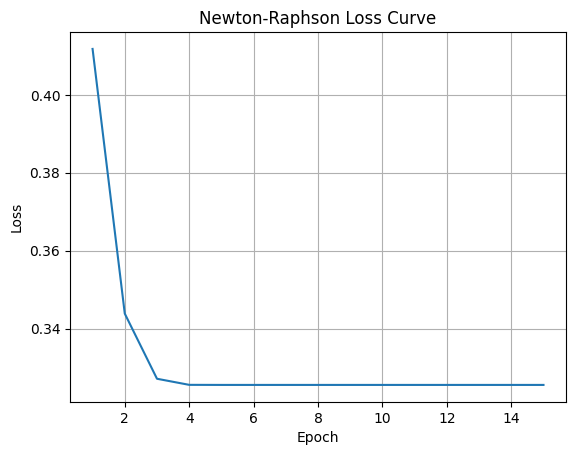

In [14]:
model = LogisticRegression()
model.trainNR(x_train, y_train, epoch=15)

In [15]:
model.save("newparam.pkl")

Validation Accuracy: 88.00% for BDG

Validation Accuracy: 90.00%


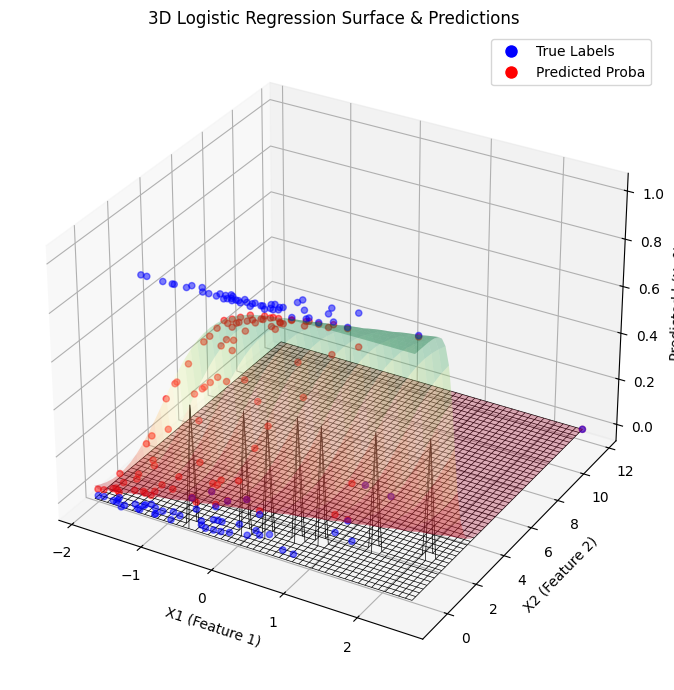

In [18]:
model_loader = LogisticRegression.Loader("newparam.pkl")
use_sgd = False

y_pred = model_loader.predict(x_val, mode='sgd' if use_sgd else 'nr')
accuracy = np.mean(y_val == y_pred) * 100
print(f"Validation Accuracy: {accuracy:.2f}%")

X_norm = x_val.copy()
if model_loader.model.normtype == 'z-score':
    X_norm = (X_norm - model_loader.model.x_mean) / model_loader.model.x_std
elif model_loader.model.normtype == 'min-maxScaling':
    X_norm = (X_norm - model_loader.model.x_min) / (model_loader.model.x_max - model_loader.model.x_min)

if model_loader.model.add_bias:
    X_norm = np.hstack([np.ones((X_norm.shape[0], 1)), X_norm])

theta = model_loader.model.thetaNR if not use_sgd else model_loader.model.thetaSGD
y_proba = LogisticRegression.h(X_norm, theta).flatten()

X1 = X_norm[:, 1]
X2 = X_norm[:, 2]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X1, X2, y_val.flatten(), c='blue', label='True Labels', alpha=0.5)
ax.scatter(X1, X2, y_proba, c='red', label='Predicted Proba', alpha=0.5)

x1_range = np.linspace(X1.min(), X1.max(), 50)
x2_range = np.linspace(X2.min(), X2.max(), 50)
X1_grid, X2_grid = np.meshgrid(x1_range, x2_range)

X_grid_features = np.c_[X1_grid.ravel(), X2_grid.ravel()]
if model_loader.model.add_bias:
    X_grid_features = np.c_[np.ones(X_grid_features.shape[0]), X_grid_features]

Z_grid = LogisticRegression.h(X_grid_features, theta).reshape(X1_grid.shape)

boundary = np.abs(Z_grid - 0.5) < 0.02
ax.plot_wireframe(X1_grid, X2_grid, Z_grid * boundary, color='black', linewidth=0.5)

ax.plot_surface(X1_grid, X2_grid, Z_grid, alpha=0.3, cmap='RdYlGn')


ax.set_xlabel("X1 (Feature 1)")
ax.set_ylabel("X2 (Feature 2)")
ax.set_zlabel("Predicted h(X, θ)")
ax.set_title("3D Logistic Regression Surface & Predictions")

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='True Labels', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Predicted Proba', markerfacecolor='red', markersize=10)
]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()
